In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1996 validated image filenames belonging to 2 classes.
Found 350 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


51877672/51877672 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/60
124/124 [==============================] - ETA: 0s - loss: 2.2547 - accuracy: 0.8551
Epoch 1: val_accuracy improved from -inf to 0.95833, saving model to /content/drive/MyDrive/dataset_xml_format/dataset_xml_format/model_checkpoint_Densenet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 70s 427ms/step - loss: 2.2547 - accuracy: 0.8551 - val_loss: 0.7768 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 2/60
124/124 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.9303
Epoch 2: val_accuracy improved from 0.95833 to 0.96726, saving model to /content/drive/MyDrive/dataset_xml_format/dataset_xml_format/model_checkpoint_Densenet.h5
124/124 [==============================] - 45s 364ms/step - loss: 0.5206 - accuracy: 0.9303 - val_loss: 0.1615 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 3/60
124/124 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.9475
Epoch 3: val_accuracy improved from 0.96726 to 0.97917, saving model to /content/drive/MyDrive/dataset_xml_format/dataset_xml_format/model_checkpoint_Densenet.h5
124/124 [==============================] - 45s 361ms/step - loss: 0.3372 - accuracy: 0.9475 - val_loss: 0.1483 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 4/60
124/124 [=======================

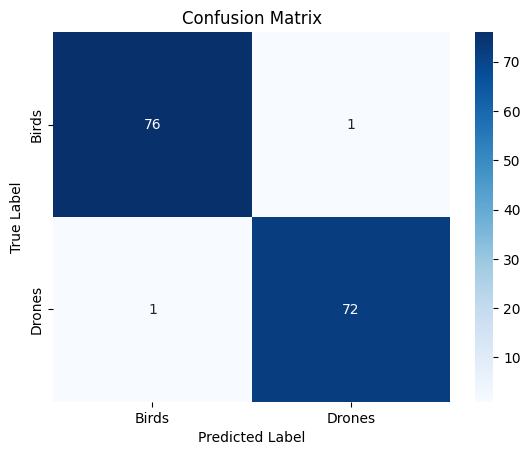

In [9]:
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet169
from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths
base_path = '/content/drive/MyDrive/dataset_xml_format/dataset_xml_format/BirdVsDrone'
birds_path = os.path.join(base_path, 'Birds')
drones_path = os.path.join(base_path, 'Drones')

# List all files in the folders
birds_files = [os.path.join(birds_path, file) for file in os.listdir(birds_path)]
drones_files = [os.path.join(drones_path, file) for file in os.listdir(drones_path)]

# Create labels
birds_labels = [0] * len(birds_files)
drones_labels = [1] * len(drones_files)

# Combine data and labels
all_data_paths = birds_files + drones_files
all_labels = birds_labels + drones_labels

# Split data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_data_paths, all_labels, test_size=0.2, random_state=42
)

# Further split the validation set
validation_paths, test_paths, validation_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.3, random_state=42
)

# Convert labels to strings
train_labels = [str(label) for label in train_labels]
validation_labels = [str(label) for label in validation_labels]
test_labels = [str(label) for label in test_labels]

# Create dataframes for train, validation, and test sets
train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
validation_df = pd.DataFrame({'path': validation_paths, 'label': validation_labels})
test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

# Use ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators from dataframes
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    validation_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',shuffle=False
)



# Freeze the layers in the base model
# Unfreeze the last 10 layers in the base model


# Define the base model (InceptionV3)
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
# Unfreeze the last 10 layers in the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create a custom model for classification
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks
checkpoint_path = '/content/drive/MyDrive/dataset_xml_format/dataset_xml_format/model_checkpoint_Densenet.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # You can change this metric based on your preference
    save_best_only=True,
    mode='max',
    verbose=1
)
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=60,
    callbacks=[checkpoint,early_stopping, reduce_lr,]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')
test_predictions = model.predict(test_generator)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Convert labels to binary format
test_labels_binary = test_df['label'].astype(int)

# Convert true labels to binary
test_true_labels = (np.array(test_generator.classes) > 0.4).astype(int)

# Generate classification report
class_report = classification_report(test_true_labels, test_predictions_binary)
print("Classification Report:")
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)
f1 = f1_score(test_true_labels, test_predictions_binary)
print(f'F1 Score: {f1}')

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Birds', 'Drones'], yticklabels=['Birds', 'Drones'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Number of birds in test set: 77
Number of drones in test set: 73
Found 1996 validated image filenames belonging to 2 classes.
Found 350 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/60


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


124/124 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9813
Epoch 1: val_accuracy improved from -inf to 0.98512, saving model to /content/drive/MyDrive/dataset_xml_format/dataset_xml_format/model_checkpoint_Densenet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 53s 358ms/step - loss: 0.0580 - accuracy: 0.9813 - val_loss: 0.1563 - val_accuracy: 0.9851 - lr: 2.0000e-04
Epoch 2/60
124/124 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9798
Epoch 2: val_accuracy did not improve from 0.98512
124/124 [==============================] - 44s 359ms/step - loss: 0.0608 - accuracy: 0.9798 - val_loss: 0.1461 - val_accuracy: 0.9851 - lr: 2.0000e-04
Epoch 3/60
124/124 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9833
Epoch 3: val_accuracy did not improve from 0.98512
124/124 [==============================] - 45s 362ms/step - loss: 0.0462 - accuracy: 0.9833 - val_loss: 0.1555 - val_accuracy: 0.9851 - lr: 2.0000e-04
Epoch 4/60
124/124 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9879
Epoch 4: val_accuracy did not improve from 0.98512
124/124 [==============================] - 42s 337ms/step - loss: 0.0365 - accuracy: 0.9879 - val_loss: 0.

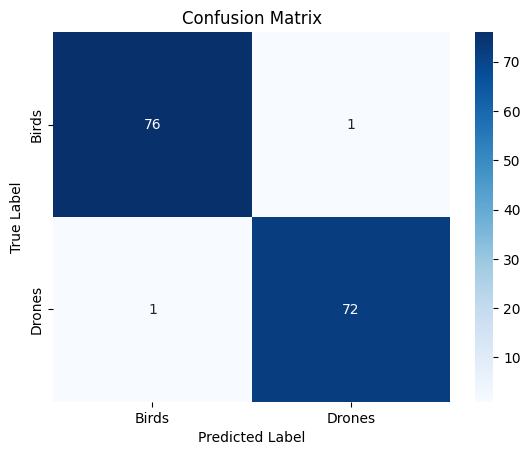

In [11]:
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the weights from the model_checkpoint.h5 file
model = load_model('/content/drive/MyDrive/dataset_xml_format/dataset_xml_format/model_checkpoint_Densenet.h5')

# Count birds and drones in the test set
bird_count = test_df[test_df['label'] == '0'].shape[0]
drone_count = test_df[test_df['label'] == '1'].shape[0]

print(f"Number of birds in test set: {bird_count}")
print(f"Number of drones in test set: {drone_count}")

# Use ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators from dataframes (assuming you have already defined train_df, validation_df, and test_df)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    validation_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary', shuffle=False
)

# Set up callbacks
checkpoint_path = '/content/drive/MyDrive/dataset_xml_format/dataset_xml_format/model_checkpoint_Densenet.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=60,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

# Make predictions on the test set
test_predictions = model.predict(test_generator)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Convert labels to binary format
test_labels_binary = test_df['label'].astype(int)

# Convert true labels to binary
test_true_labels = (np.array(test_generator.classes) > 0.4).astype(int)

# Generate classification report
class_report = classification_report(test_true_labels, test_predictions_binary)
print("Classification Report:")
print(class_report)
f1 = f1_score(test_true_labels, test_predictions_binary)
print(f'F1 Score: {f1}')
# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Birds', 'Drones'], yticklabels=['Birds', 'Drones'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
